Lab ML for Data Science: Part I

In [1]:
import numpy as np
import pandas as pd
import torch,torch.optim
import scipy,scipy.spatial
import sklearn,sklearn.datasets
import seaborn as sns
from matplotlib import pyplot as plt


# 1 Loading the Data, Preprocessing, Initial Data Analysis

The first step will consist of **downloading the dataset and converting it into numerical tables (e.g. numpy, arrays)**.
In practice, raw data is rarely directly usable as input to machine learning algorithms. In particular, there may be substantial heterogeneity between the different input features. Some features may be physical measurements, monetary measurements, while others may be category indicators or even non-numerical data such as text or images. Hence, a **preliminary filtering** of what is interesting for the analysis we would like to conduct is desirable.

In the context of the UCI wholesale dataset, one may, for example, want to base anomaly and cluster predictions on numerical data (annual spending per category) and drop meta-data such as Channel and the Region indicators or reserve it for an ulterior use. Once such a preliminary step has been taken, we have a standard dataset of size $N × d$ where $N$ is the number of instances (wholesale customers), $d$ is the number of spending categories, and each value in the table can be expressed in monetary unit.

To verify the range and distribution of these values, we can **generate some basic statistical visualizations** of the data. This includes **histograms** showing for each category the distribution of spendings, or **scatter plots** showing the correlation between different product categories. A common observation from such basic statistical analysis is that the distributions are heavy tailed, with many instances having rather small spendings, whereas a few may have spendings one or two orders of magnitude above. 

Any anomaly detection algorithm would systematically highlight those high spenders as anomalous and not make a distinction between spending little and not spending at all.
To address this issue, it can be useful to apply some **nonlinear transformation** to the data, for example, applying the log function to the features so that the distribution becomes compressed for large values and expanded for small values.

$x → log(x + θ)$

Here, we add a positive offset $θ$ in the logarithm so that zero spending $(x = 0)$ does not get mapped to $−∞$. You may experiment with different offsets, such as $θ = 1, θ = 10$ or $θ = 100$. To verify the effect of the transformation, you can **recompute the histograms and scatter plots** in transformed space and check visually whether the transformation had the desired result, e.g. whether the distribution look Gaussian-distributed.

# Loading and understanding the Data

In [2]:
data_pd = pd.read_csv('Wholesale customers data.csv')
data_pd.head()

,Channel,Region,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
0,2,3,12669,9656,7561,214,2674,1338
1,2,3,7057,9810,9568,1762,3293,1776
2,2,3,6353,8808,7684,2405,3516,7844
3,1,3,13265,1196,4221,6404,507,1788
4,2,3,22615,5410,7198,3915,1777,5185


In [3]:
data_pd.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 440 entries, 0 to 439
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype
---  ------            --------------  -----
 0   Channel           440 non-null    int64
 1   Region            440 non-null    int64
 2   Fresh             440 non-null    int64
 3   Milk              440 non-null    int64
 4   Grocery           440 non-null    int64
 5   Frozen            440 non-null    int64
 6   Detergents_Paper  440 non-null    int64
 7   Delicassen        440 non-null    int64
dtypes: int64(8)
memory usage: 27.6 KB


It seems like the dataset has no missing values.

In [4]:
data_pd.duplicated().sum()

0

There do not appear to be any duplicate entries.

In [5]:
data_pd.describe()

,Channel,Region,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
count,440.000000,440.000000,440.000000,440.000000,440.000000,440.000000,440.000000,440.000000
mean,1.322727,2.543182,12000.297727,5796.265909,7951.277273,3071.931818,2881.493182,1524.870455
std,0.468052,0.774272,12647.328865,7380.377175,9503.162829,4854.673333,4767.854448,2820.105937
min,1.000000,1.000000,3.000000,55.000000,3.000000,25.000000,3.000000,3.000000
25%,1.000000,2.000000,3127.750000,1533.000000,2153.000000,742.250000,256.750000,408.250000
50%,1.000000,3.000000,8504.000000,3627.000000,4755.500000,1526.000000,816.500000,965.500000
75%,2.000000,3.000000,16933.750000,7190.250000,10655.750000,3554.250000,3922.000000,1820.250000
max,2.000000,3.000000,112151.000000,73498.000000,92780.000000,60869.000000,40827.000000,47943.000000


For now, we only want to analyse the numerical data. So we won't look at the metadata such as Channel and Region as suggested in the task.

In [6]:
data_features = data_pd.iloc[:,2:]

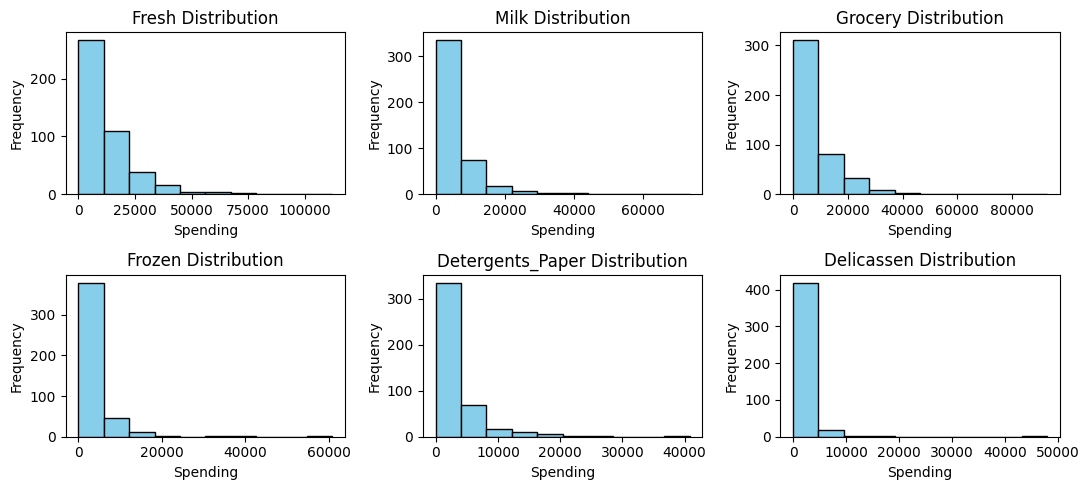

In [7]:
#Plot histograms for each product category
plt.figure(figsize=(11, 5))

for i, column in enumerate(data_features.columns):
    plt.subplot(2, 3, i+1)
    plt.hist(data_features[column], bins=10, color='skyblue', edgecolor='black')
    plt.title(column + ' Distribution')
    plt.xlabel('Spending')
    plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

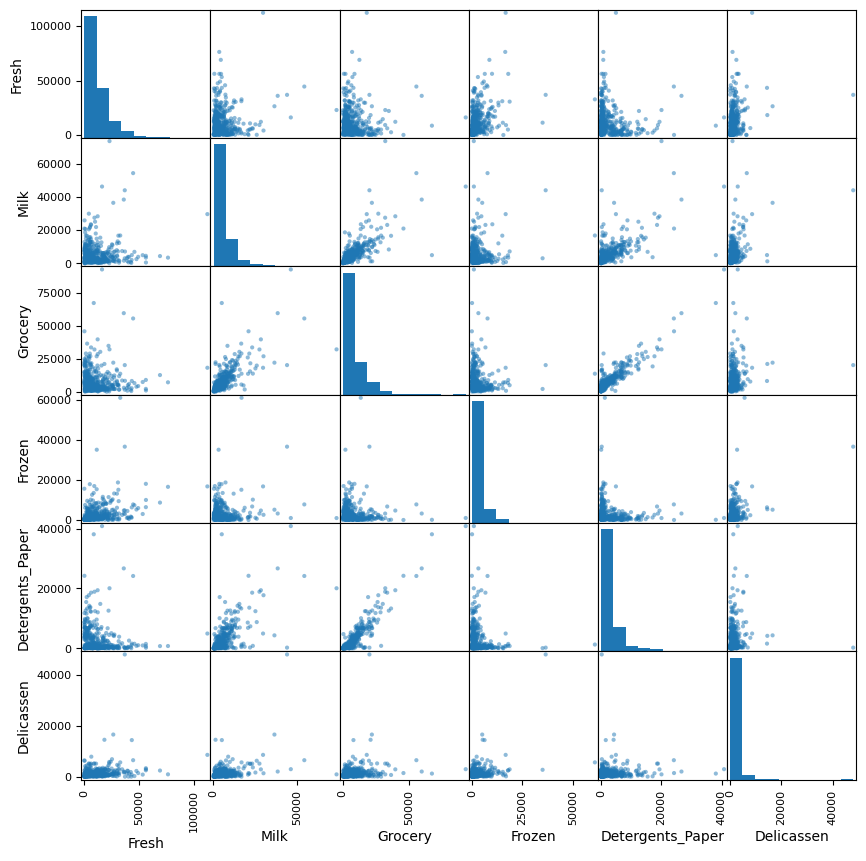

In [8]:
pd.plotting.scatter_matrix(data_features, figsize=(10, 10))
plt.show()

In [9]:
data_features.corr()

,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
Fresh,1.000000,0.100510,-0.011854,0.345881,-0.101953,0.244690
Milk,0.100510,1.000000,0.728335,0.123994,0.661816,0.406368
Grocery,-0.011854,0.728335,1.000000,-0.040193,0.924641,0.205497
Frozen,0.345881,0.123994,-0.040193,1.000000,-0.131525,0.390947
Detergents_Paper,-0.101953,0.661816,0.924641,-0.131525,1.000000,0.069291
Delicassen,0.244690,0.406368,0.205497,0.390947,0.069291,1.000000


Through the basic statistical visualizations we could see that the distributions are heavy tailed, with many instances having rather small spendings, whereas a few may have spendings one or two orders of magnitude above. Also there are some instances in Frozen, Detergents_Paper and Delicassen that have huge spendings. 

It also seems like Milk and Grocery could be correlating and even Milk and Detergents_Paper. More likely though there seems to be a high correclation between Grocery and Detergents_Paper.

# Preprocessing with log-transformation


In [10]:
#Try different offsets for the log-transformation
offset = 1e-10
#offset = 1
#offset = 10
#offset = 100
data_log = data_pd.copy()
data_log.iloc[:,2:] = data_features.apply(lambda x: np.log(x + offset))
data_log_features = data_log.iloc[:,2:]

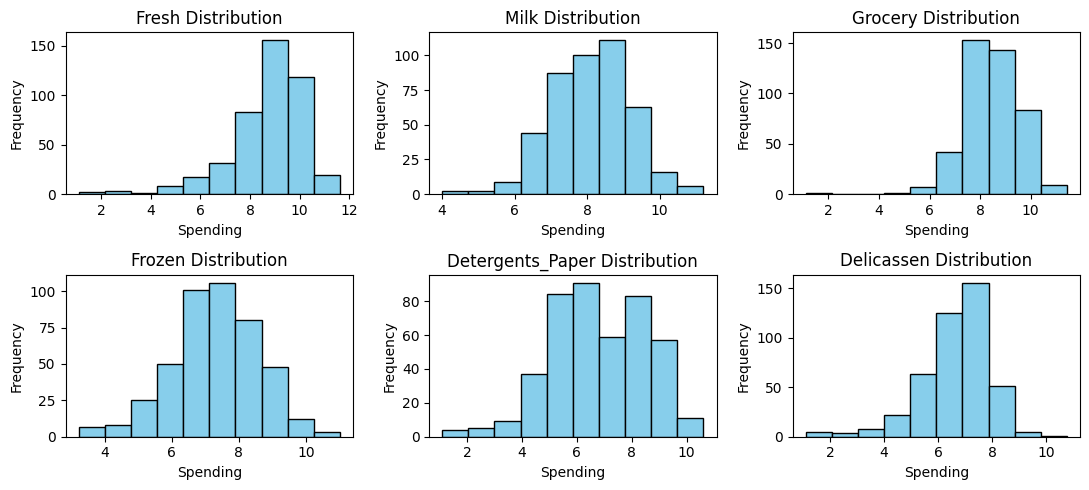

In [11]:
#Plot histograms for each product category
plt.figure(figsize=(11, 5))

for i, column in enumerate(data_log_features.columns):
    plt.subplot(2, 3, i+1)
    plt.hist(data_log_features[column], bins=10, color='skyblue', edgecolor='black')
    plt.title(column + ' Distribution')
    plt.xlabel('Spending')
    plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

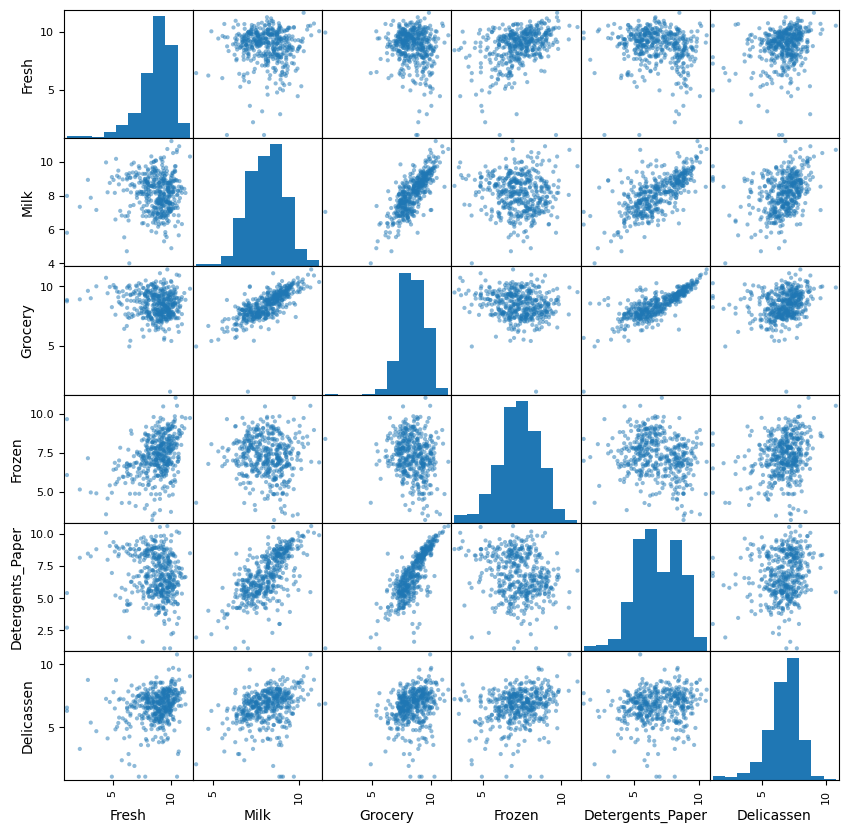

In [12]:
pd.plotting.scatter_matrix(data_log_features, figsize=(10, 10))
plt.show()

In [13]:
data_log_features.corr()

,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
Fresh,1.000000,-0.019834,-0.132713,0.383996,-0.155871,0.255186
Milk,-0.019834,1.000000,0.758851,-0.055316,0.677942,0.337833
Grocery,-0.132713,0.758851,1.000000,-0.164524,0.796398,0.235728
Frozen,0.383996,-0.055316,-0.164524,1.000000,-0.211576,0.254718
Detergents_Paper,-0.155871,0.677942,0.796398,-0.211576,1.000000,0.166735
Delicassen,0.255186,0.337833,0.235728,0.254718,0.166735,1.000000


Now that we have transformed the data and it looks somewhat Gaussian distributed. We can see that our assumptions still hold, and in some cases the correlation has gotten stronger. But for the correlation between Grocery and Detergents_Paper, which we thought was the strongest, it looks like they're not too strongly correlated because the value dropped around 0.12.

# 2 Detecting Anomalies
We now focus on a question of interest, specifically, whether there are anomalous instances in the given data. A basic form of anomaly detection is to verify for each data point whether it has neighbors. A simple measure of anomaly can then be given by the **distance (or squared distance) to the nearest neighbor**. For example, given some test point with index j in the dataset, one can get its outlier score by performing a minimum over the $N − 1$ remaining points in the data, i.e.:

$
z_{jk} = ||x_j − x_k||^2
$

$
y_j = \displaystyle\min_{k \neq j} z_{jk}
$

With such anomaly scores, data points can now be ranked from most to least anomalous. For example, one may now be able to extract a top-10 list of the most anomalous instances in the dataset, and print for these 10 instances their recorded spending across categories.

In [14]:
#Calculate the sqaured distance of our transformed data
def squared_distance(data):
    data_distance = scipy.spatial.distance.cdist(data, data, 'sqeuclidean')
    return data_distance

data_distance = squared_distance(data_log_features)
print(data_distance)

[[ 0.          4.96624074  9.54107037 ...  5.72166805 14.4066924
  21.46875525]
 [ 4.96624074  0.          2.37818463 ...  6.26794639 13.98649068
  32.81875466]
 [ 9.54107037  2.37818463  0.         ...  9.92282759 15.6470797
  46.83261384]
 ...
 [ 5.72166805  6.26794639  9.92282759 ...  0.         31.9874944
  42.07956921]
 [14.4066924  13.98649068 15.6470797  ... 31.9874944   0.
  24.27550014]
 [21.46875525 32.81875466 46.83261384 ... 42.07956921 24.27550014
   0.        ]]


In [15]:
#Since we don't want the 0 values from the distances from one instance to itself we masked our distance graph
masked_data_distance = np.ma.masked_equal(data_distance, 0.)

#Calculate the samllest distance between to instances to get the anomaly score of each instance
min_data_distance = np.min(masked_data_distance, axis=1)

#Display the 10 most anomalous instances
def k_most_anomalous_data(data,a_score,k=10):
    k_smallest = np.argsort(a_score)
    k_smallest = np.flip(k_smallest)
    data_k_smallest = data.iloc[k_smallest[:k],:]
    return data_k_smallest

k_most_anomalous_data(data_log,min_data_distance,10)

,Channel,Region,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
338,1,2,1.098612,5.808142,8.856661,9.655090,2.708050,6.309918
75,1,3,9.923192,7.036148,1.098612,8.390949,1.098612,6.882437
154,1,3,6.432940,4.007333,4.919981,4.317488,1.945910,2.079442
142,1,3,10.519646,8.875147,9.018332,8.004700,2.995732,1.098612
95,1,3,1.098612,7.979339,8.740657,6.086775,5.407172,6.563856
204,1,1,7.578657,6.792344,8.561401,7.232010,1.609438,7.191429
128,1,3,4.941642,9.087834,8.248791,4.955827,6.967909,1.098612
187,1,3,7.798933,8.987447,9.192075,8.743372,8.148735,1.098612
183,1,3,10.514529,10.690808,9.911952,10.505999,5.476464,10.777768
109,2,3,7.248504,9.724899,10.274568,6.511745,6.728629,1.098612


## 2.1 Robust anomaly models
In practice, however, Eq. (1) may not identify top outliers in a way that is sufficiently reproducible. Imagine, for example, a point $x_j$ whose nearest neighbor, call it $x_i$ is at a distance of 1 but the second nearest neighbor is at a distance of 10. If the nearest point $x_i$ was not in the dataset (e.g. due to slight variations in the data collection process), the outlierness score of $x_j$ would have changed drastically. An efficient way of addressing this problem is to reconsider the notion of outlierness by considering a point to be an outlier based on multiple neighbors. In other words, a point may still be an outlier even if (by accident) some other point in the data shares roughly the same values.

Such a redefined notion of outlierness can be implemented by replacing the hard minimum in the original equation by a soft minimum, i.e.:

$y_j$ = soft $\displaystyle\min_{k \neq j} z_{jk}$

with:

soft $\displaystyle\min_{k \neq j} z_{jk} = - \frac{1}{\gamma} \log({\frac{1}{N-1}} \displaystyle\sum_{k \neq j} exp(- \gamma z_{jk}))$

As a side note, the softmin can be interpreted as a generalized F-mean with $F(t) = exp(−γt)$. The output of such function is also related to the log-likelihood prediced by a kernel density estimator of the rest of the data (see e.g. [2]).



In [16]:
#Default gamma value for the first calculation
gamma = 1.

def softmin(distances, gamma):
    n_minus_one_frac = 1/(distances.shape[0]-1)
    data_without_diagonal = distances[~np.eye(*distances.shape, dtype=bool)].reshape(distances.shape[0],distances.shape[1]-1)
    minus_gamma_data_distance = -gamma * data_without_diagonal
    soft_min_data_distance = -1/gamma * (scipy.special.logsumexp(minus_gamma_data_distance,axis=1,b=n_minus_one_frac))
    return soft_min_data_distance

anomaly_score = softmin(data_distance,gamma)
print(anomaly_score)

[ 5.10754404  3.49428969  5.10369655  4.00625603  4.52754055  4.0097153
  4.37788194  3.53193132  4.29813945  3.75444638  4.43045343  3.98847223
  5.47769333  4.71326148  5.04027279  4.58766761  4.98922009  5.65787255
  3.76454445  4.37468514  3.74451959  3.71470131  5.87135294  8.56615086
  5.0026057   6.60153357  3.42494479  4.9332429   5.14684615  4.84003368
  3.90196549  4.4977777   5.04864041  4.42098974  5.52884517  5.13705472
  4.65857809  4.02826688  6.89211306  7.41225076  5.03422246  4.04740573
  6.64787071  6.62328076  6.34568952  4.91787135  3.95102872  7.82060781
  3.83007936  4.30371379  4.49001727  5.4583226   4.92999866  5.02666971
  3.64605853  3.91363369  4.91575872  5.92190174  4.07352703  5.54879171
  6.39704398  6.85181761  4.37488047  3.80005037  4.67140943 12.66202526
 10.96760598  3.99901445  5.88281094  5.22388976  4.43352172  9.23735071
  6.20180209  4.84962282  3.57588949 29.69987136  7.1066828   4.42454392
  4.25955852  4.90963998  4.69980595  5.97243536  3.

In [17]:
def average_and_spread_of_score(a_score, gamma):
    anomaly_score_mean = np.mean(a_score)
    anomaly_score_std = np.std(a_score)
    print("The mean µ of the anomaly score is:",anomaly_score_mean,"and the spread σ is:",anomaly_score_std,"for γ:", gamma)

average_and_spread_of_score(anomaly_score,gamma)

k_most_anomalous_data(data_log,anomaly_score,10)

The mean µ of the anomaly score is: 5.621165345662516 and the spread σ is: 2.9412546591831568 for γ: 1.0


,Channel,Region,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
338,1,2,1.098612,5.808142,8.856661,9.655090,2.708050,6.309918
75,1,3,9.923192,7.036148,1.098612,8.390949,1.098612,6.882437
154,1,3,6.432940,4.007333,4.919981,4.317488,1.945910,2.079442
142,1,3,10.519646,8.875147,9.018332,8.004700,2.995732,1.098612
95,1,3,1.098612,7.979339,8.740657,6.086775,5.407172,6.563856
187,1,3,7.798933,8.987447,9.192075,8.743372,8.148735,1.098612
128,1,3,4.941642,9.087834,8.248791,4.955827,6.967909,1.098612
183,1,3,10.514529,10.690808,9.911952,10.505999,5.476464,10.777768
204,1,1,7.578657,6.792344,8.561401,7.232010,1.609438,7.191429
109,2,3,7.248504,9.724899,10.274568,6.511745,6.728629,1.098612


## 2.2 Selecting a suitable parameter γ

To verify the gain in terms of reproducibility one can gain from using the softmin approach to detect anomalies, one can apply the bootstrap method in statistics. Bootstrap consists of simulating multiple variants of the same datasets by randomly sampling instances (with repetition) from the original dataset. The anomaly scores can then be computed for each variant of the dataset, and for each instance, one can characterize its anomalousness by two values, its average and its spread. In other words, the anomaly of an instance is modeled, not by a single value $y_j$ , but by a random variable $y_j$ of mean $µ_j$ and spread $σ_j$ .

A large value for the parameter γ of the softmin anomaly model of Eq. (2) may produce stark differences between the $µ_j$ ’s of anomalous and non-anomalous instances, but also large spreads $σ_j$ ’s within each instance. Conversely, a small value of γ can reduce these spreads, but also at the cost of reducing differences between instances. In practice, a neither too small nor too large value of γ is likely to achieve the maximum separability between anomalous and non-anomalous instances.

To find a suitable parameter γ, you may for example plot for each instance its anomaly average and spread, repeat the plot for different parameters γ, and then chose the parameter γ that produces the best separability on a visual level. Even better, you may formalize this visual intuition into some evaluation metric based on which you can derive an optimal parameter γ. Note that once you have selected a parameter γ, you can recompute a single anomaly model with this parameter γ on the whole data. This single model can then be used for the analyses in the next section.

In [18]:
#Create multiple variants of the same dataset by sampling instances eith repetition
def variants_sim(data,num_variants,num_instances):
    int_num_instannces= int(num_instances)
    variants = []

    for i in range(num_variants):
        instances = np.random.choice(data.shape[0], int_num_instannces)
        variants.append(data.iloc[instances,:])
    
    return variants

variants = variants_sim(data_log_features,100,data_log.shape[0])

#Different gammas for testing
gamma = [0.001, 0.01, 0.1, 1.]
        

In [19]:
def gamma_selection(data, gamma_list, variants):
    mean_score_depending_on_gamma = np.zeros((len(gamma_list),data.shape[0]))
    std_score_depending_on_gamma = np.zeros((len(gamma_list),data.shape[0]))
    for g_index,g in enumerate(gamma_list):
        a_score_depending_on_gamma = np.zeros((data.shape[0],len(variants)))
        for v_num,v in enumerate(variants):
            v_distances = squared_distance(v)
            v_anomaly_scores = softmin(v_distances,g)
            for rowindex,score in enumerate(v_anomaly_scores):
                getindex = v.index[rowindex]
                a_score_depending_on_gamma[getindex,v_num] = np.mean(a_score_depending_on_gamma[getindex,v_num] + score)
        mean_score_depending_on_gamma[g_index] = np.mean(a_score_depending_on_gamma,axis=1)
        std_score_depending_on_gamma[g_index] = np.std(a_score_depending_on_gamma,axis=1)
    return mean_score_depending_on_gamma,std_score_depending_on_gamma

mean_score_depending_on_gamma, std_score_depending_on_gamma = gamma_selection(data_log_features,gamma,variants)

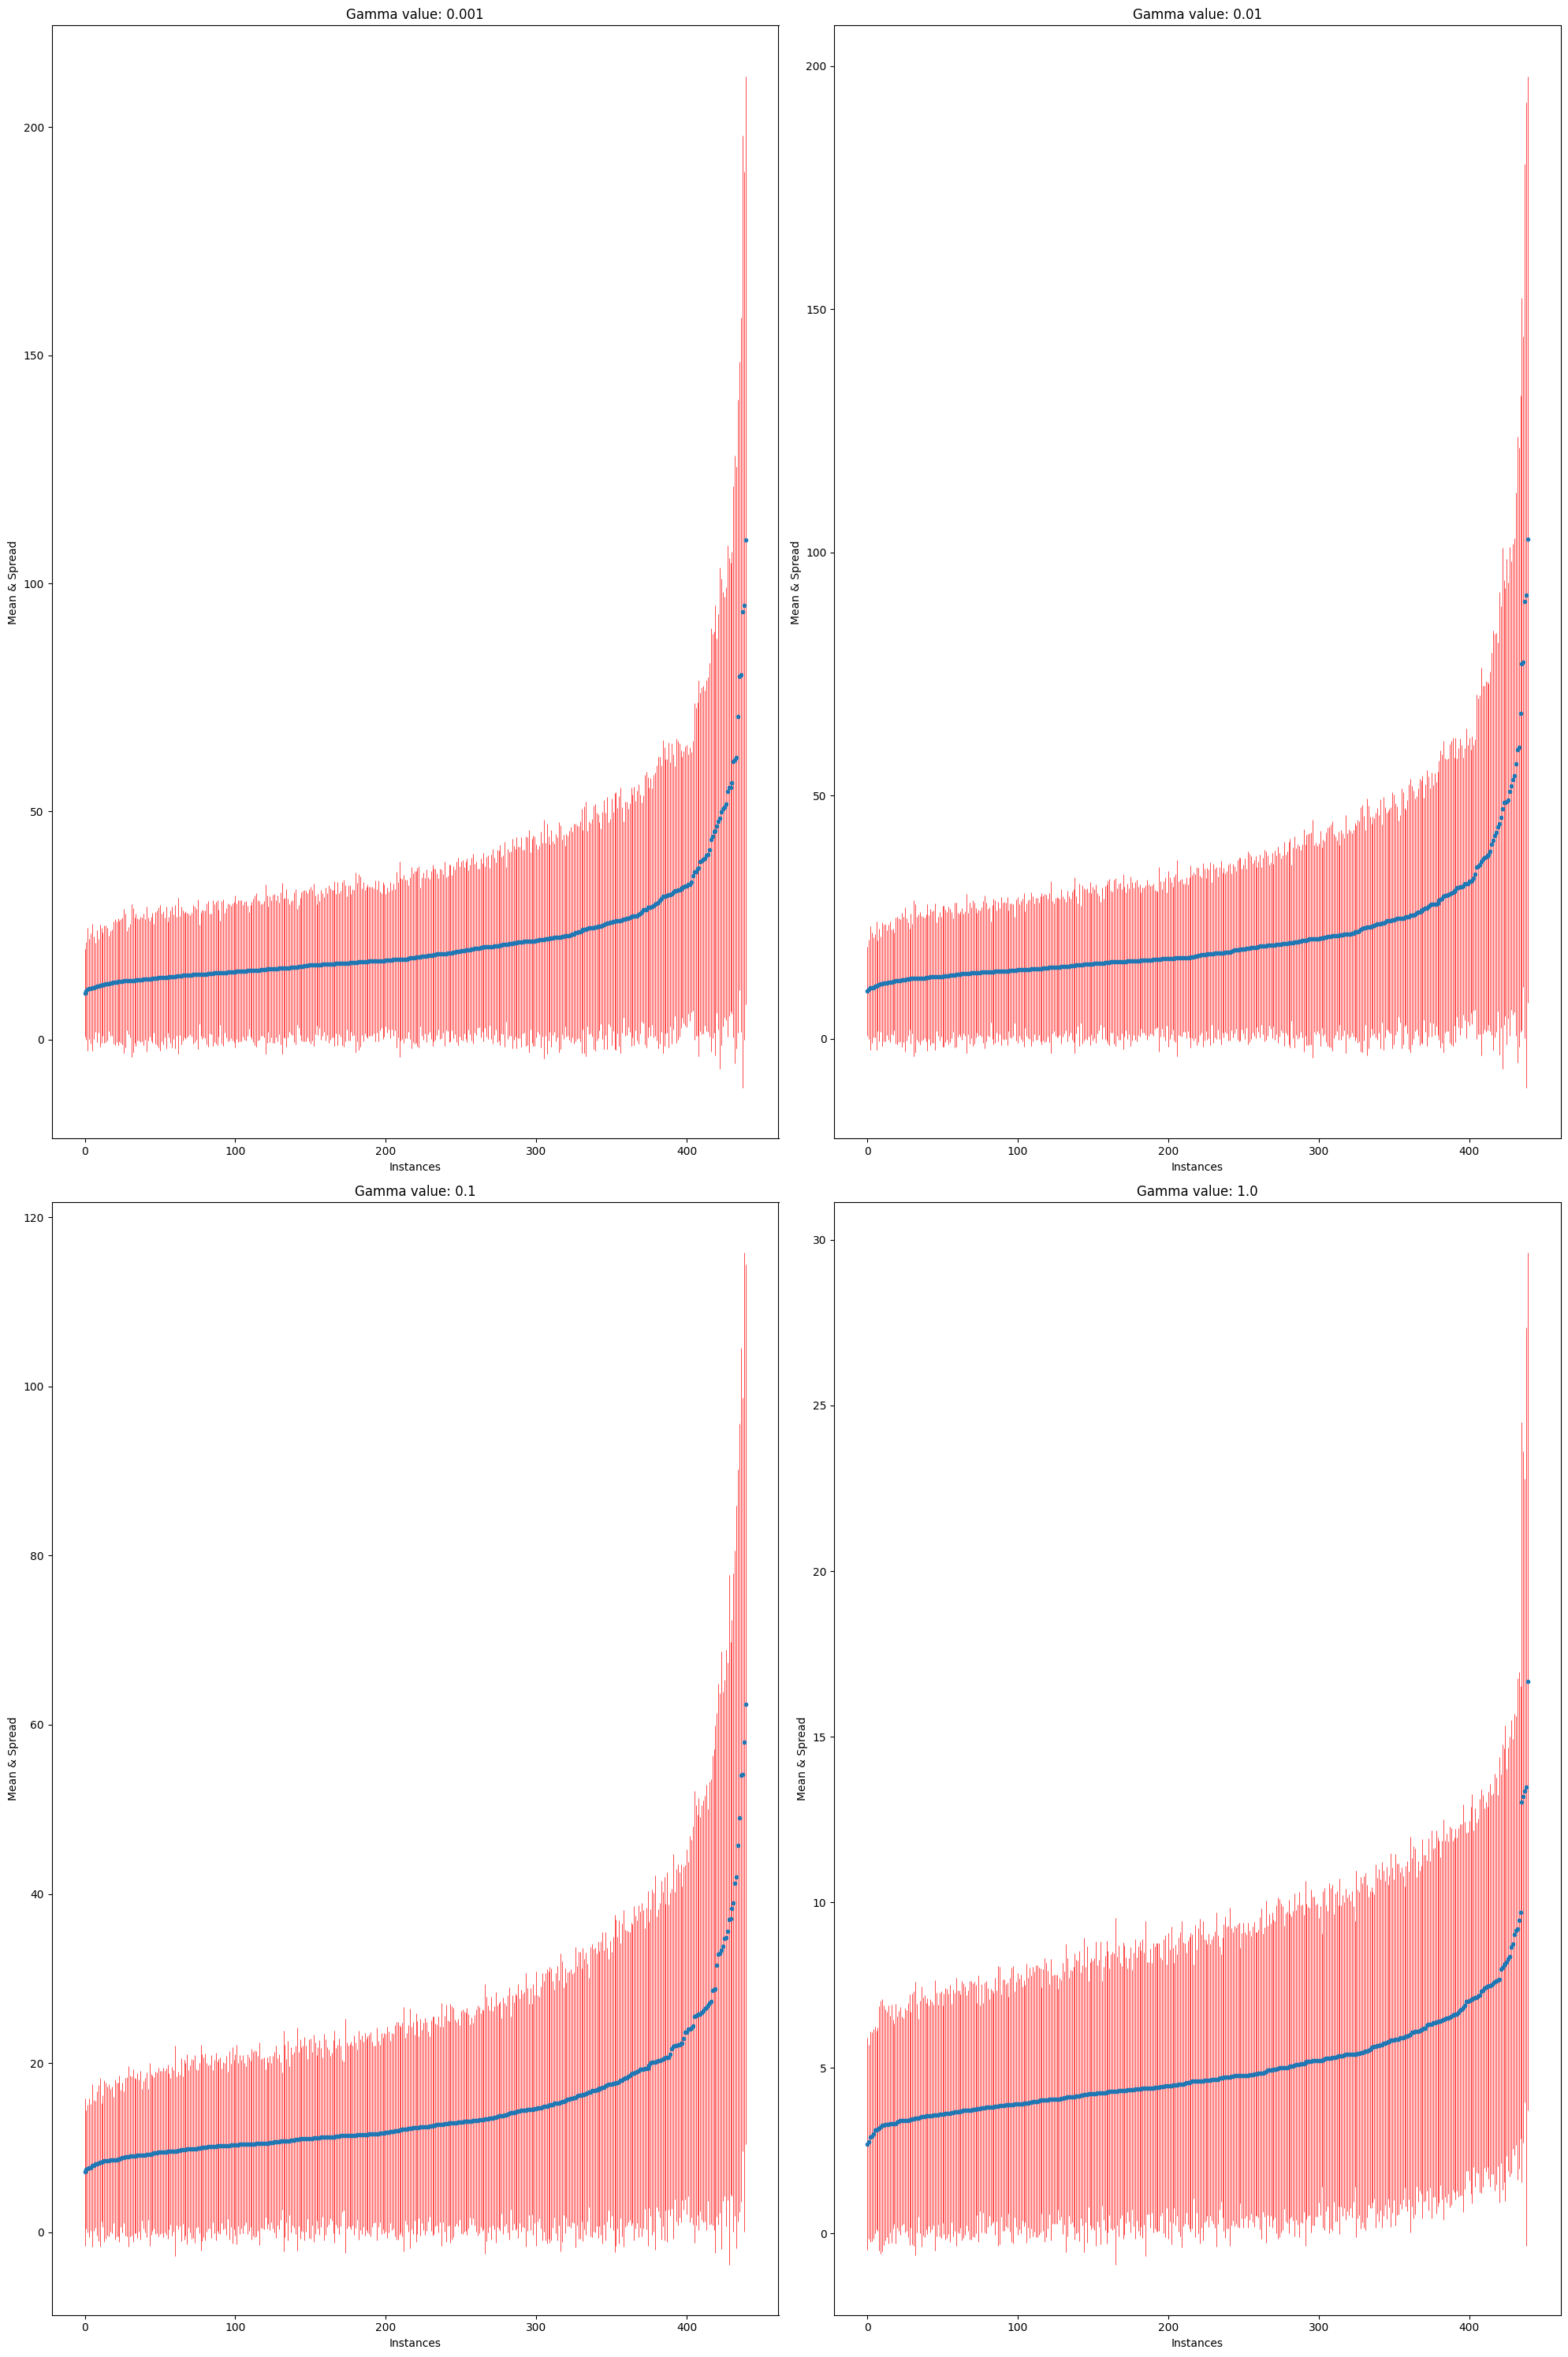

In [20]:
num_instances = [ins for ins in range(len(mean_score_depending_on_gamma[0]))]

plt.figure(figsize=(20, 30))

for i, gamma_value in enumerate(gamma):
    plt.subplot(2, 2, i+1)
    stats = zip(mean_score_depending_on_gamma[i],std_score_depending_on_gamma[i])
    sorted_stats = sorted(stats)
    sorted_stats0 = [stat[0] for stat in sorted_stats]
    sorted_stats1 = [stat[1] for stat in sorted_stats]
    plt.title('Gamma value: ' + str(gamma_value))
    plt.xlabel('Instances')
    plt.ylabel('Mean & Spread')
    
    plt.errorbar(num_instances,sorted_stats0,sorted_stats1,linestyle='None', marker='.',ecolor="red",elinewidth=0.5)

plt.tight_layout()
plt.show()

We can see that with the γ-value of 0.01 we get the most seperation of instances with really small and high anomaly-score-means.
For higher γ-values the means are more clustered together. 
Therefore we choose $γ = 0.01$ going forward.

In [21]:
gamma = 0.01
#Recalculate the anomaly scores with the new gamma
anomaly_score = softmin(data_distance,gamma)

average_and_spread_of_score(anomaly_score,gamma)
k_most_anomalous_data(data_log,anomaly_score,10)

The mean µ of the anomaly score is: 20.654694713006943 and the spread σ is: 10.88884370957702 for γ: 0.01


,Channel,Region,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
338,1,2,1.098612,5.808142,8.856661,9.655090,2.708050,6.309918
75,1,3,9.923192,7.036148,1.098612,8.390949,1.098612,6.882437
154,1,3,6.432940,4.007333,4.919981,4.317488,1.945910,2.079442
95,1,3,1.098612,7.979339,8.740657,6.086775,5.407172,6.563856
66,1,3,2.197225,7.335634,8.911530,5.164786,8.151333,3.295837
128,1,3,4.941642,9.087834,8.248791,4.955827,6.967909,1.098612
65,2,3,4.442651,9.950323,10.732651,3.583519,10.095388,7.260523
142,1,3,10.519646,8.875147,9.018332,8.004700,2.995732,1.098612
218,2,1,2.890372,8.923191,9.629380,7.158514,8.475746,8.759669
161,1,3,9.428190,6.291569,5.645447,6.995766,1.098612,7.711101


# 3 Getting Insights into Anomalies
In a data science setting, only detecting anomalies may be of limited interest. While it helps the scientist to answer the basic question of whether there are anomalies in the data, one may wish for deeper insights, for example, whether anomalies are under/over-represented among specific types of retailers, or, for specific instances, which features (i.e. spending categories) contribute predominantly to instances being anomalous.

In [22]:
insight = k_most_anomalous_data(data_log,anomaly_score,100)
insight.groupby(["Region"]).count()


,Channel,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
Region,,,,,,,
1,16,16,16,16,16,16,16
2,9,9,9,9,9,9,9
3,75,75,75,75,75,75,75


In [23]:
insight.groupby(["Channel"]).count()


,Region,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
Channel,,,,,,,
1,57,57,57,57,57,57,57
2,43,43,43,43,43,43,43


## 3.1 Relation Between Anomalies and Meta-Data
We may be interested to know whether different subsets of the data (e.g. retailers of a specific type or in a particular geographical locations) have more or less anomalies on average. Such insights can be obtained by taking into consideration the meta-data. Your analysis could take the form of plotting the distribution of anomaly scores on different subsets of data, where these subsets are determined based on the meta-data.
You may then look for differences in distribution.

In [24]:
data_meta = data_log.iloc[:,:2].copy()
data_meta["Anomaly_Score"] = anomaly_score
data_meta["Mean"] = mean_score_depending_on_gamma[1]
data_meta["Spread"] = std_score_depending_on_gamma[1]
print(data_meta)

     Channel  Region  Anomaly_Score       Mean     Spread
0          2       3      17.089691  18.181843  17.832931
1          2       3      14.054544  13.917476  14.005709
2          2       3      18.291005  19.209999  19.022265
3          1       3      14.711866  14.925312  15.455591
4          2       3      16.757701  20.074081  18.720998
..       ...     ...            ...        ...        ...
435        1       3      23.510222  20.561236  21.821070
436        1       3      23.892689  24.623922  23.793165
437        2       3      25.711017  20.563137  24.517993
438        1       3      14.952472  16.585526  15.781768
439        1       3      28.963179  25.334040  28.141901

[440 rows x 5 columns]


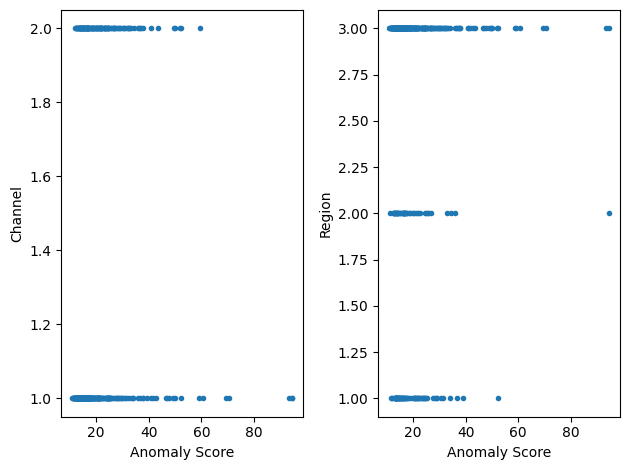

In [25]:
for i,meta_feature in enumerate(data_meta.iloc[:,:2]):
    plt.subplot(1, 2, i+1)
    plt.plot(anomaly_score,data_meta.iloc[:,i],'.')
    plt.xlabel("Anomaly Score")
    plt.ylabel(meta_feature)
    
plt.tight_layout()
plt.show()

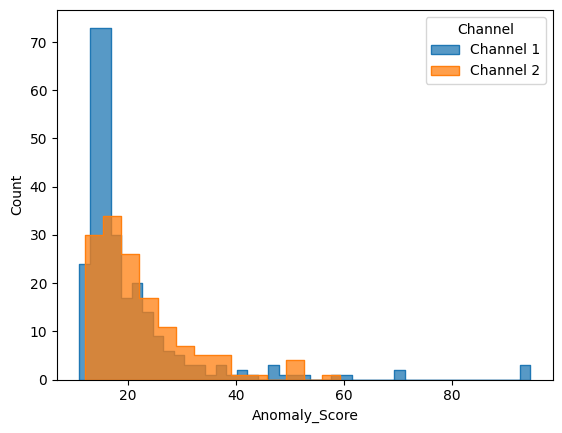

In [26]:
def plot_different_subsets(df, feature):
    for i in df[feature].value_counts().index:
        subset = df[df[feature] == i]
        sns.histplot(subset["Anomaly_Score"], label=f'{feature} {i}', element='step')
    plt.legend(title=feature)    

plot_different_subsets(data_meta,"Channel")

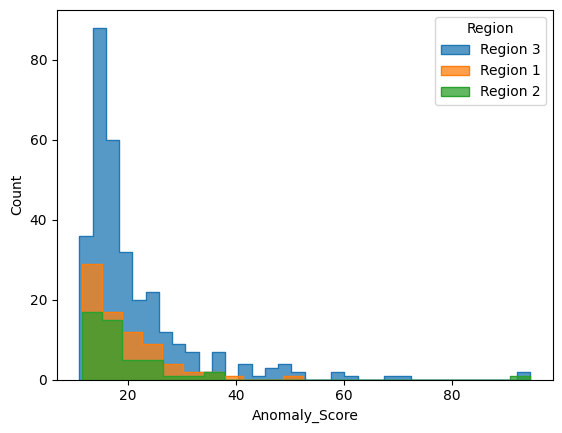

In [27]:
plot_different_subsets(data_meta,"Region")  

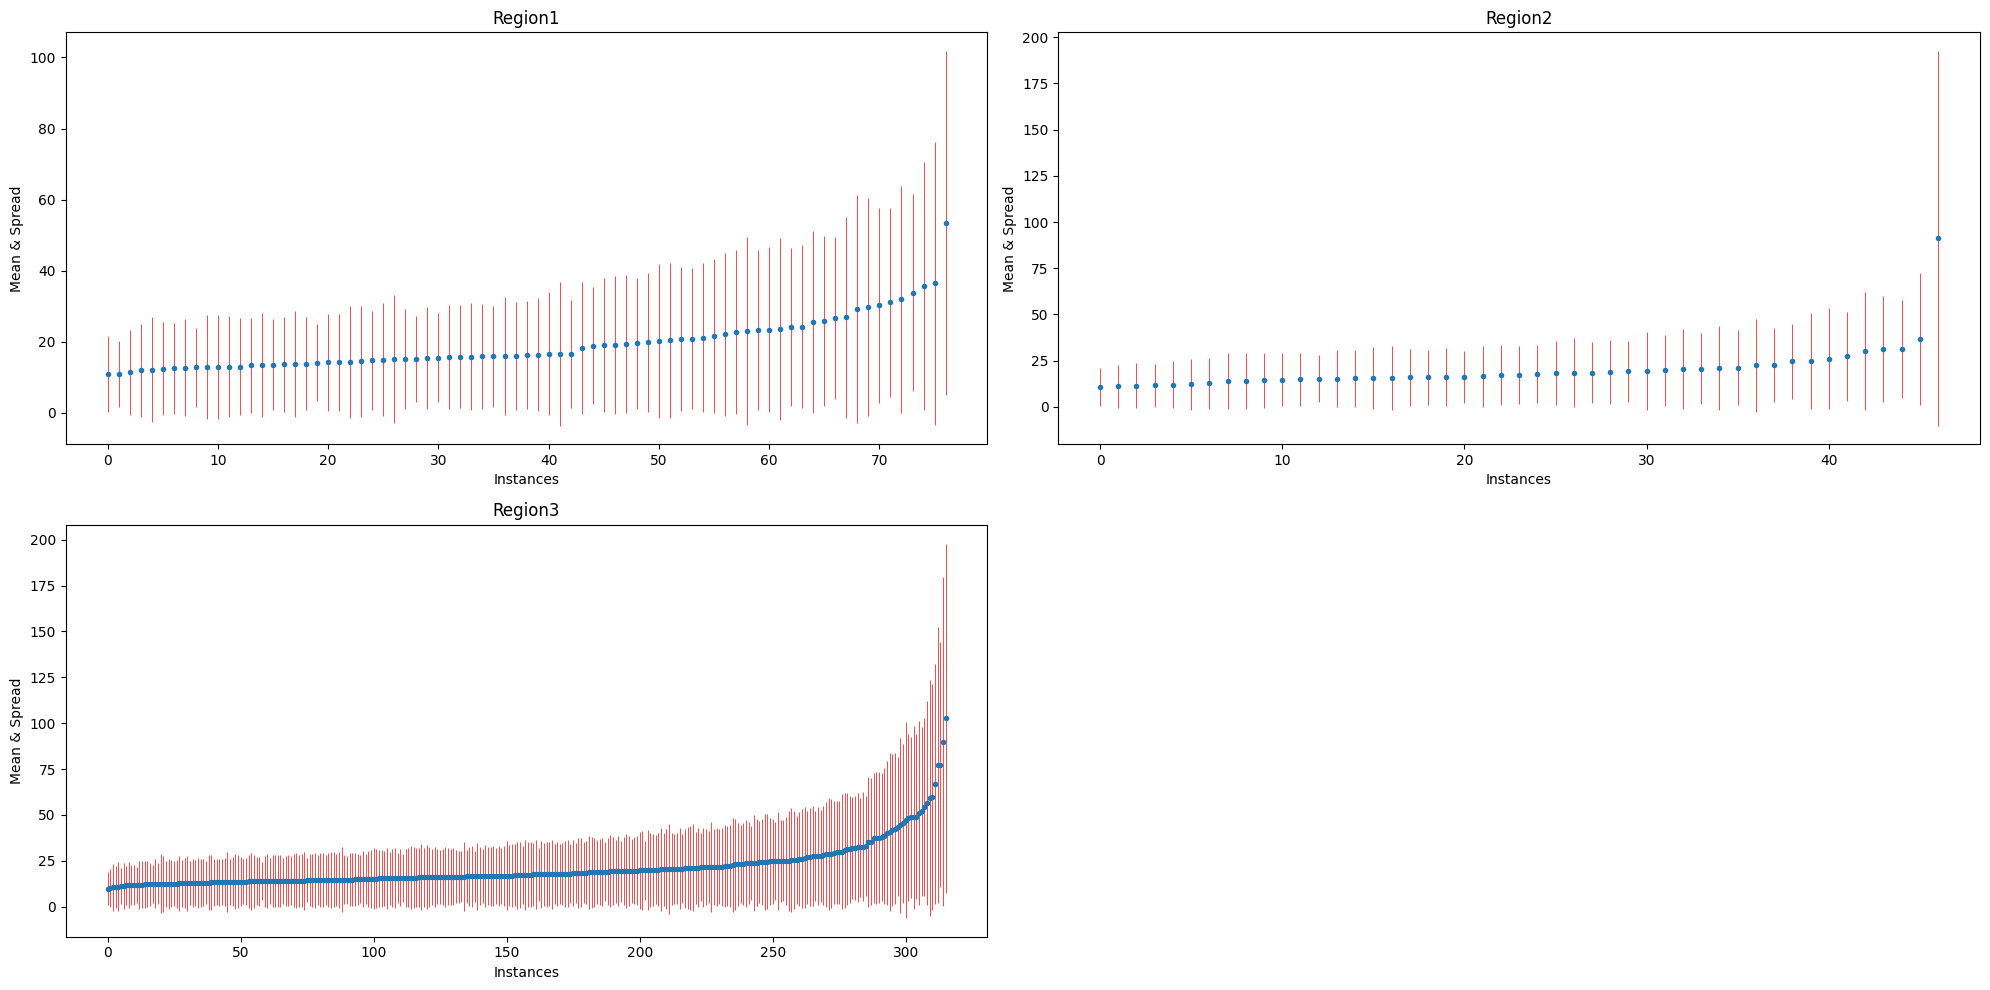

In [28]:
def meta_errorbar(df, feature):
    plt.figure(figsize=(20, 10))
    for i in df[feature].value_counts().index:
        plt.subplot(2, 2, i)
        subset = df[df[feature] == i]
        num_instances = [ind for ind in range(subset.shape[0])]
        plt.errorbar(num_instances,subset["Mean"],subset["Spread"],linestyle='None', marker='.',ecolor="red",elinewidth=0.5)
        plt.title(feature + str(i))
        plt.xlabel('Instances')
        plt.ylabel('Mean & Spread')
    plt.tight_layout()
    plt.show()


meta_errorbar(data_meta.sort_values("Mean"),"Region")

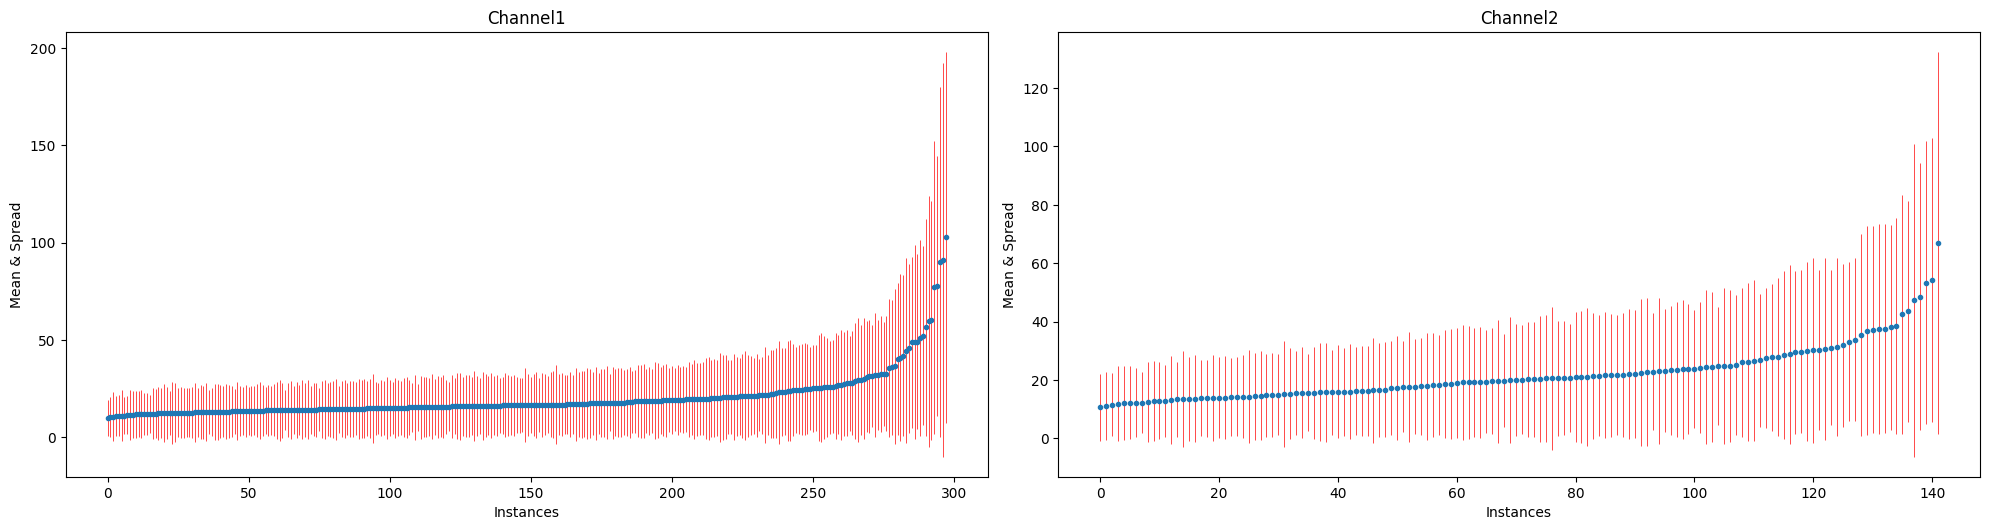

In [29]:
meta_errorbar(data_meta.sort_values("Mean"),"Channel")

## 3.2 Indentifying Input Features that Drive Anomaly
Identifying relevant input features can be achieved using a set of techniques commonly referred to as Explainable AI. We consider in particular the Layer-wise Relevance Propagation method (see [1] for an overview). In the context of the anomaly detection models considered here, attribution of anomaly scores to the input features can be achieved in two steps [2]: First, one identifies to what extent each data point k other than j has contributed to the anomaly score of instance j:

$R_k^{(j)} = \displaystyle\frac{exp(−γz_{jk})}{\sum_{k \neq j}exp(−γz_{jk})} * y_j$

In [30]:
data_distance

array([[ 0.        ,  4.96624074,  9.54107037, ...,  5.72166805,
        14.4066924 , 21.46875525],
       [ 4.96624074,  0.        ,  2.37818463, ...,  6.26794639,
        13.98649068, 32.81875466],
       [ 9.54107037,  2.37818463,  0.        , ...,  9.92282759,
        15.6470797 , 46.83261384],
       ...,
       [ 5.72166805,  6.26794639,  9.92282759, ...,  0.        ,
        31.9874944 , 42.07956921],
       [14.4066924 , 13.98649068, 15.6470797 , ..., 31.9874944 ,
         0.        , 24.27550014],
       [21.46875525, 32.81875466, 46.83261384, ..., 42.07956921,
        24.27550014,  0.        ]])

In [31]:
gamma = 0.01
r_k_j = np.zeros((data_distance.shape))
for row,j in enumerate(data_distance):
    for column,k in enumerate(j):
        r_k_j[row][column] = np.exp(-gamma*k)/(np.sum(np.exp(-gamma*j))-np.exp(-gamma*k))*anomaly_score[row]
r_k_j

array([[0.04618376, 0.04394043, 0.04197069, ..., 0.0436089 , 0.03997278,
        0.03724131],
       [0.03505638, 0.036846  , 0.03597785, ..., 0.03460189, 0.03202574,
        0.02651807],
       [0.04546377, 0.04884877, 0.05002762, ..., 0.04529011, 0.04276451,
        0.03128776],
       ...,
       [0.07151485, 0.07112417, 0.06856479, ..., 0.07573842, 0.05495994,
        0.04967385],
       [0.03423455, 0.03437904, 0.03381158, ..., 0.02870463, 0.03955362,
        0.0310107 ],
       [0.07106804, 0.06342604, 0.05511652, ..., 0.05780485, 0.06909638,
        0.08813881]])

The variable $R_k^{(j)}$ indicates the contribution of data point k to the anomaly score of instance j. Then, these scores can be propagated back to the input features by observing that the (squared) Euclidean distance entering the anomaly score can be decomposed in terms of individual components:

$R_i^{(j)} = \displaystyle\sum_{k \neq j} \frac{[x_k − x_j]_i^{2}}{||x_j − x_k||^2} * R_k^{(j)}$

In [32]:
def rij(data):
    r_i_j = np.zeros(data.iloc[:,2:].shape)
    feature_distance = np.zeros(data.shape[0])
    

    for rowj in range(data.shape[0]):
        for featurei in range(data.iloc[:,2:].shape[1]):
            for columnk in range(data.shape[0]):
                if rowj != columnk:
                    feature_distance[columnk] = (data.iloc[columnk,featurei] - data.iloc[rowj,featurei]) ** 2 / data_distance[rowj][columnk] * r_k_j[rowj][columnk]
            r_i_j[rowj][featurei] = np.sum(feature_distance)
            feature_distance = np.zeros(data.shape[0])
    return r_i_j

r_i_j = rij(data_log)
print(r_i_j)

[[ 0.92739577  1.30787607  2.42127851  2.08785343  1.24746029  6.25714218]
 [ 1.11198856  2.32735299  2.29444315  2.20993895  1.5408543   2.18713937]
 [ 0.93714053  1.41913306  2.1667565   1.85909679  1.32525593  2.17752661]
 ...
 [ 0.67225402  1.62118032  3.34842871  2.99631193  4.13215625  4.51579742]
 [ 0.24219418  2.06860956  1.98676144  1.39912585  1.37430527  2.58757508]
 [ 0.32902983  1.02300449  2.80143813  1.49443018  1.40782734 11.22749993]]


In [33]:
print(np.sum(r_i_j,axis=1)==anomaly_score)

[False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False Fa

440 x 6

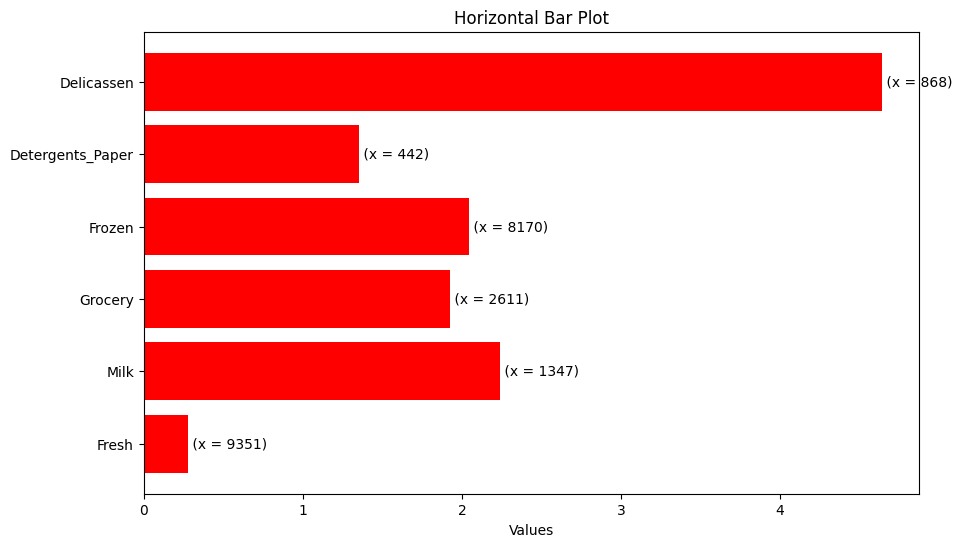

In [34]:
def plot_feature_contribution(data, instance):
    categories = data.columns[2:]
    # Creating the bar plot
    plt.figure(figsize=(10, 6))
    bars = plt.barh(categories, r_i_j[instance], color='red')
    
    # Adding text labels to the bars
    for bar, value in zip(bars, data.iloc[instance,2:]):
        plt.text(bar.get_width(), bar.get_y() + bar.get_height() / 2, f' (x = {value})', va='center')
    
    plt.xlabel('Values')
    plt.title('Horizontal Bar Plot')
    plt.show()


plot_feature_contribution(data_pd, 337)

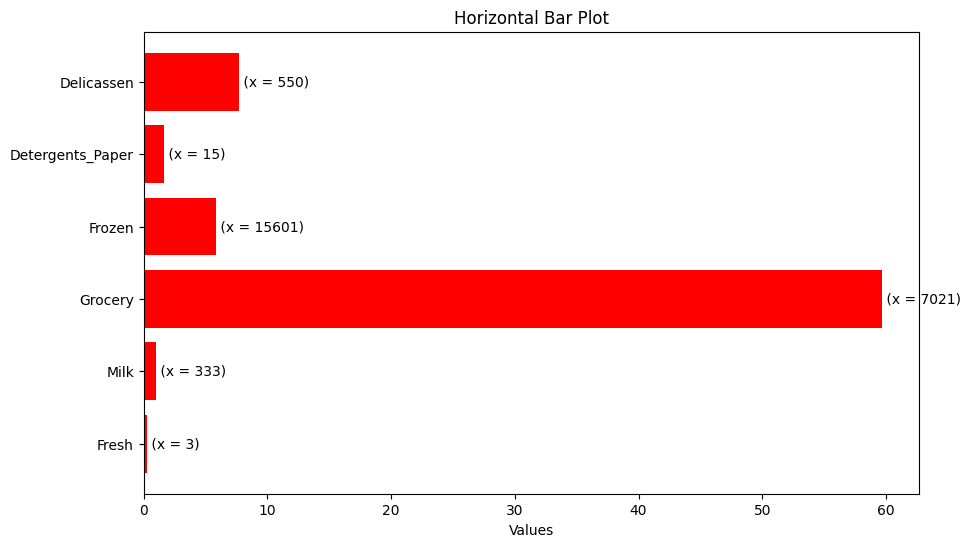

In [35]:
plot_feature_contribution(data_pd, 338)